<a href="https://colab.research.google.com/github/HarmanDotpy/GANs/blob/master/Vanilla_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple Generative Adversarial Networks (GAN's)
Using simple Fully Connectedd Neural Networks

Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.utils.data as Dataloader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd.variable import Variable
from IPython import display


Generator Network

In [0]:
class Generator(nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

Discriminator Network

In [0]:
LayerArray1 = [784 ,1024, 512 , 256, 1]
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Sequential(
        nn.Linear(LayerArray1[0],LayerArray1[1]),
        nn.LeakyReLU(0.2),
        nn.Dropout()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(LayerArray1[1], LayerArray1[2]),
        nn.LeakyReLU(0.2),
        nn.Dropout()

    )
    self.fc3 = nn.Sequential(
        nn.Linear(LayerArray1[2], LayerArray1[3]),
        nn.LeakyReLU(0.2),
        nn.Dropout(),
    )
    self.fc4 = nn.Sequential(
        nn.Linear(LayerArray1[3], LayerArray1[4]),
        nn.Sigmoid()
    )
# use leaky relu if required
  def forward(self, x):
    out = x.reshape(x.size(0),784)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    out = self.fc4(out)
    return out


Defining Hyperparameters and Viewing model structure

In [35]:
# Hyperparameters
gen_learningrate = 0.0002
dis_learningrate = 0.0002
batchsize = 100

# initialize model
genmodel = Generator()
dismodel = Discriminator()

# optimizers
genoptimizer = torch.optim.Adam(genmodel.parameters(), lr = gen_learningrate) 
disoptimizer = torch.optim.Adam(dismodel.parameters(), lr = dis_learningrate) 

# lossfunctions
lossfunction = nn.BCELoss()
print(genmodel)
print()
print(dismodel)


Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

Discriminator(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5

Loading and visualizing MNIST data

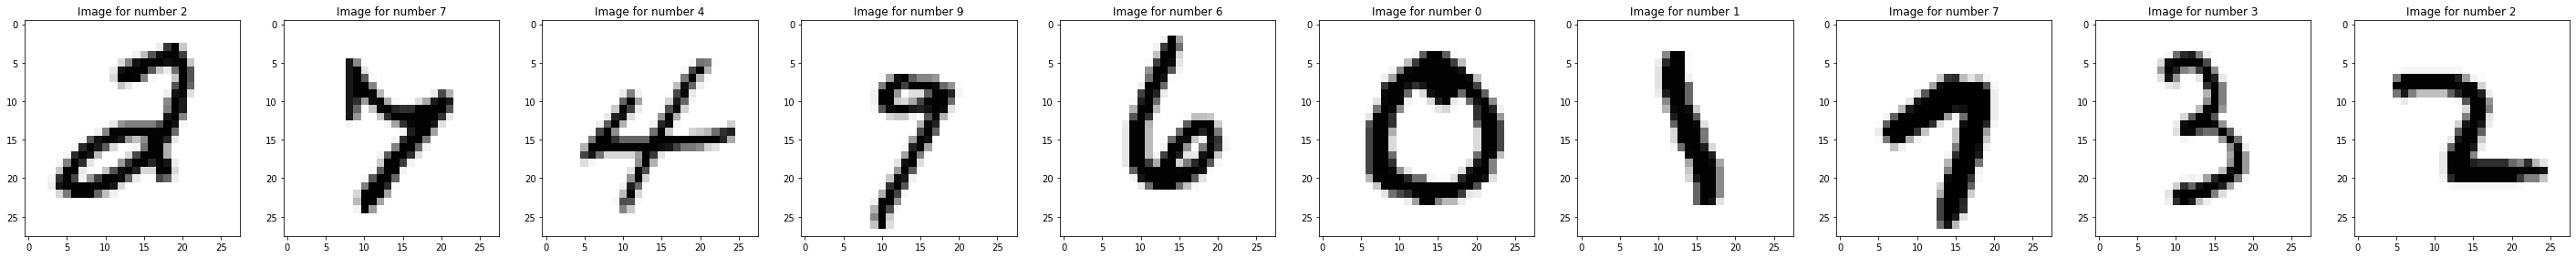

In [36]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))
        ])
    out_dir = './dataset'
    trainset= torchvision.datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)
    return trainloader
# Load data
trainloader = mnist_data()
dataiter = iter(trainloader)
images, labels = dataiter.next()

figure, axis = plt.subplots(1,10)
for i in range(10):
  axis[i].imshow(images[i].reshape(28,28), cmap = 'Greys')
  axis[i].set_title('Image for number {}'.format(labels[i])) 

figure.set_size_inches(w = 50,h = 5)
plt.show()


Loading and Visualizing Noise data(which will be a linear input to the generator)

tensor([[-0.8369,  0.5509, -1.1450,  ...,  1.4193, -1.5245,  0.6937],
        [ 0.3819,  0.6551,  1.3453,  ...,  1.4319, -0.5283, -0.3466],
        [ 0.1739, -0.9084,  0.0975,  ...,  0.9159,  0.8530, -2.3533],
        ...,
        [-0.2015, -0.5471, -1.0516,  ...,  1.1962, -1.5397,  0.1752],
        [-0.3830, -0.8931, -0.7166,  ...,  0.3069,  1.2572,  0.3030],
        [ 1.3060, -0.9911,  0.6772,  ...,  0.3586,  0.3726,  1.6034]])


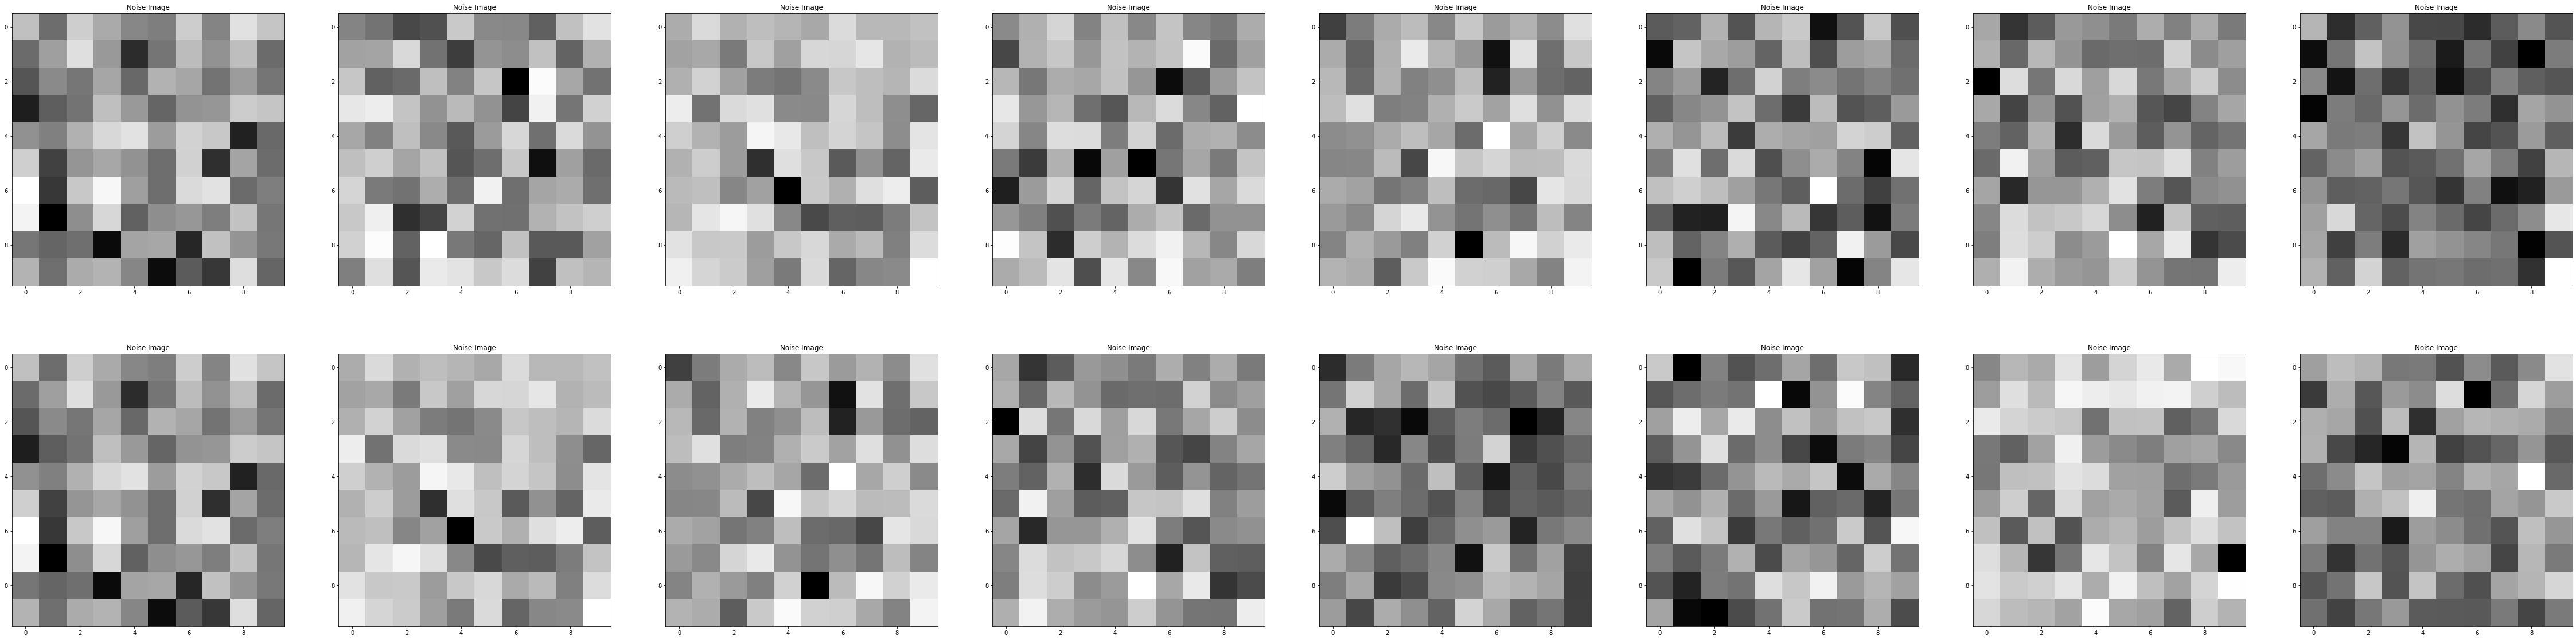

In [37]:
def noisebatch(batchsize, size):
  noisedata = torch.randn(batchsize, size)
  return noisedata

# a test batch for reviewing the process while training
testsize = 16
noisedata = noisebatch(testsize, 100)
print(noisedata)

figure, axis = plt.subplots(2,8)
for i in range(2):
  for j in range(8):
    axis[i,j].imshow(noisedata[(i+1) * j].reshape(10,10), cmap = 'Greys')
    axis[i,j].set_title('Noise Image')

figure.set_size_inches(w = 80, h = 20)

Defining arrays of Ones and Zeros for utilization in BCELoss

In [0]:
def labels_ones(size):
  return torch.ones(size, 1)
  
def labels_zeros(size):
  return torch.zeros(size, 1)

Discriminator Train function

In [0]:
def traindiscriminator(realdata, fakedata):
  disoptimizer.zero_grad()
  # forward propagation and loss calculation
  outputs_real = dismodel(realdata)
  loss_onrealdata = lossfunction(outputs_real, labels_ones(realdata.size(0)))
  outputs_fake = dismodel(fakedata)
  loss_onfakedata = lossfunction(outputs_fake, labels_zeros(realdata.size(0)))
  totalloss = loss_onrealdata + loss_onfakedata

  # backprop- reset optimizer, get gradients for both real and false data and take update step
  totalloss.backward()
  disoptimizer.step()

  # return the following for visualization
  return totalloss, loss_onrealdata, loss_onfakedata


Generator Train function

In [0]:
def traingenerator(fakedata):
  genoptimizer.zero_grad()
  # get outputlabels by passong fakedata through discriminator
  outputs_fake = dismodel(fakedata)
  lossforgenmodel = lossfunction(outputs_fake, labels_ones(fakedata.size(0)))
  
  lossforgenmodel.backward()
  genoptimizer.step()

  return lossforgenmodel

Training

In [41]:
  disloss_list = []
  realloss = []
  fakeloss = []
  generatorlosslist = []
  testing_images = []

# for each epoch
  totalsteps = len(trainloader)
  num_epochs = 10
  for epoch in range(num_epochs):
    for i, (images,_) in enumerate(trainloader):
      
      # train discriminator
      fakedata = genmodel(noisebatch(images.size(0), 100)).detach()
      discriminatorloss, loss_real, loss_fake = traindiscriminator(images, fakedata)

      disloss_list.append(discriminatorloss)
      realloss.append(loss_real)
      fakeloss.append(loss_fake)

      # train generator
      fake_data = genmodel(noisebatch(images.size(0), 100))
      generatorloss = traingenerator(fake_data)
      

      generatorlosslist.append(generatorloss)

      if(i % 100 == 0):
        images_linear = genmodel(noisedata)
        disoutput = dismodel(images_linear)
        GenLoss =lossfunction(disoutput, labels_ones(disoutput.size(0)))
        testing_images.append(images_linear)
        print('Epoch [{}/{}], Step [{}/ {}], GenLoss ={},discriminator output on fake data = {}'.format(epoch+1, num_epochs, i, totalsteps, GenLoss, disoutput[0]))

Epoch [1/10], Step [0/ 600], GenLoss =0.6825800538063049,discriminator output on fake data = tensor([0.5007], grad_fn=<SelectBackward>)
Epoch [1/10], Step [100/ 600], GenLoss =0.16990776360034943,discriminator output on fake data = tensor([0.6725], grad_fn=<SelectBackward>)
Epoch [1/10], Step [200/ 600], GenLoss =1.11318039894104,discriminator output on fake data = tensor([0.2703], grad_fn=<SelectBackward>)
Epoch [1/10], Step [300/ 600], GenLoss =5.543294429779053,discriminator output on fake data = tensor([0.0002], grad_fn=<SelectBackward>)
Epoch [1/10], Step [400/ 600], GenLoss =1.175308108329773,discriminator output on fake data = tensor([0.5397], grad_fn=<SelectBackward>)
Epoch [1/10], Step [500/ 600], GenLoss =0.3441353142261505,discriminator output on fake data = tensor([0.6353], grad_fn=<SelectBackward>)
Epoch [2/10], Step [0/ 600], GenLoss =0.34420353174209595,discriminator output on fake data = tensor([0.8231], grad_fn=<SelectBackward>)
Epoch [2/10], Step [100/ 600], GenLoss =

Visualizing The generated data over the course of training

60


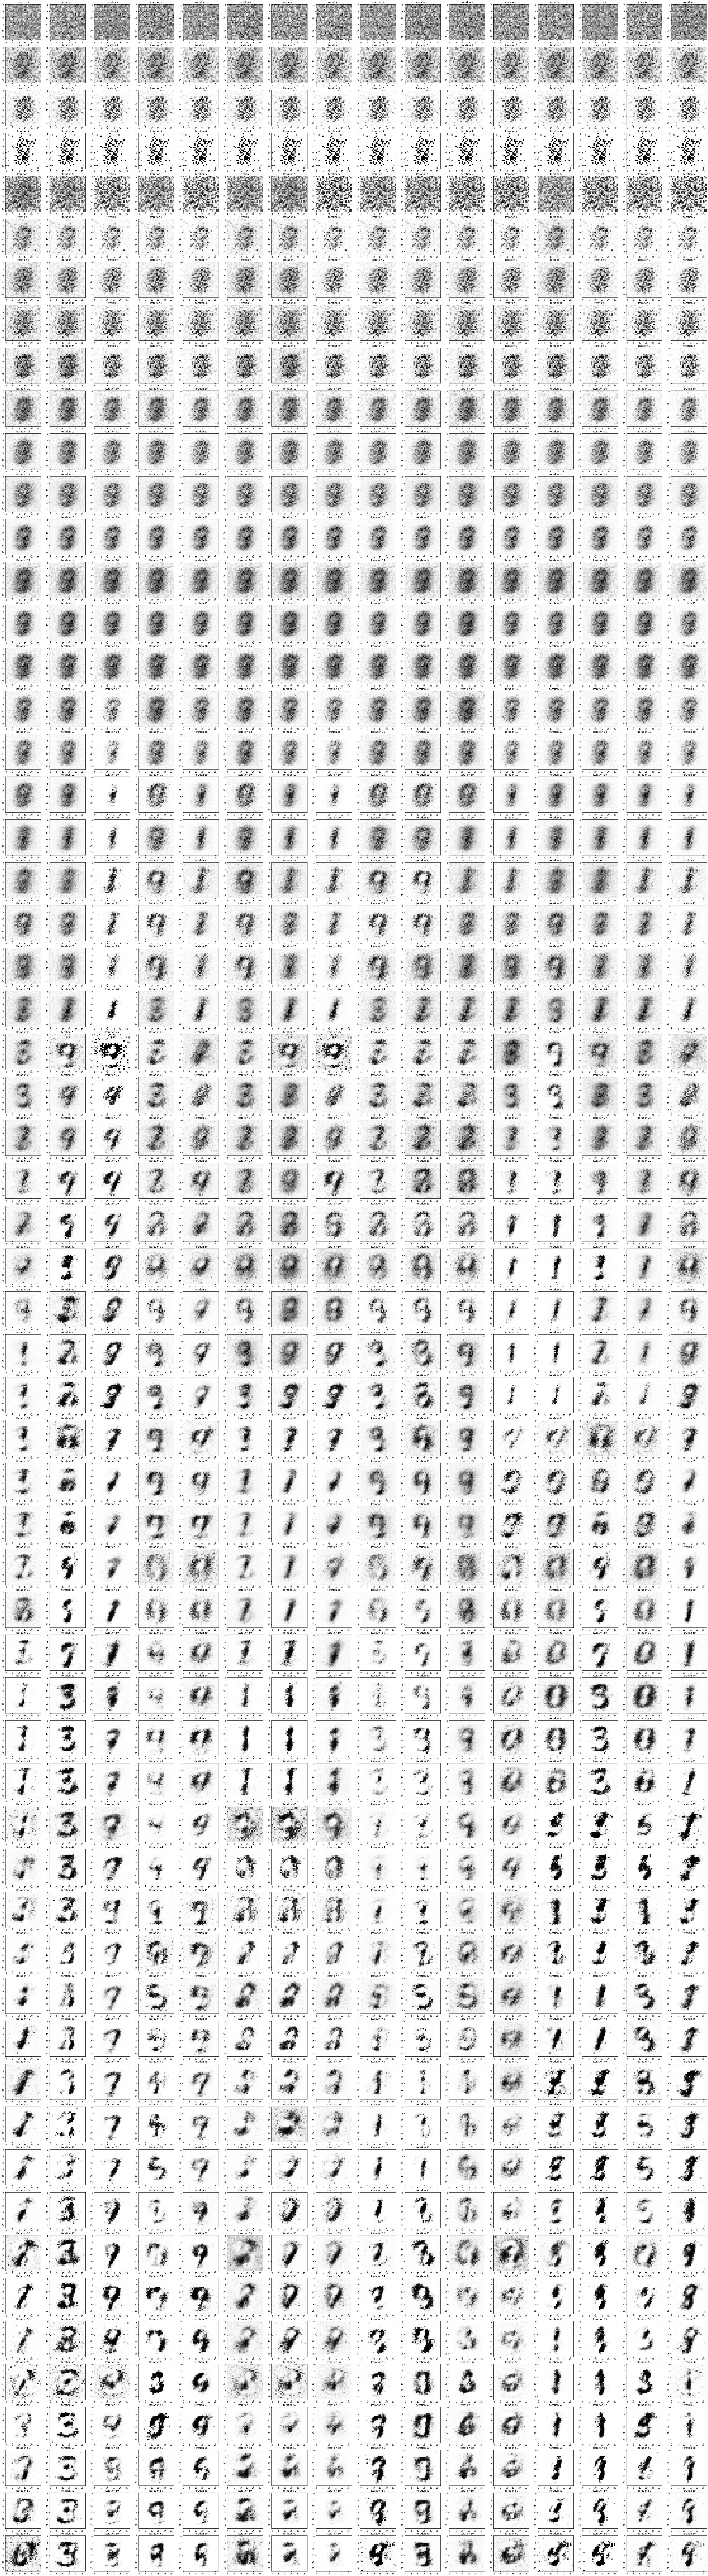

In [60]:
print(len(testing_images))
figure, axes = plt.subplots(60,16)
for i in range(len(testing_images)):
  for j in range(16):
    axes[i,j].imshow(testing_images[i][j].detach().reshape(28,28), cmap = 'Greys')
    axes[i,j].set_title('Iteration {}'.format(i+1))
figure.set_size_inches(w = 16 * 4,h = len(testing_images)* 4 )
plt.show()

Visualizing Loss plots

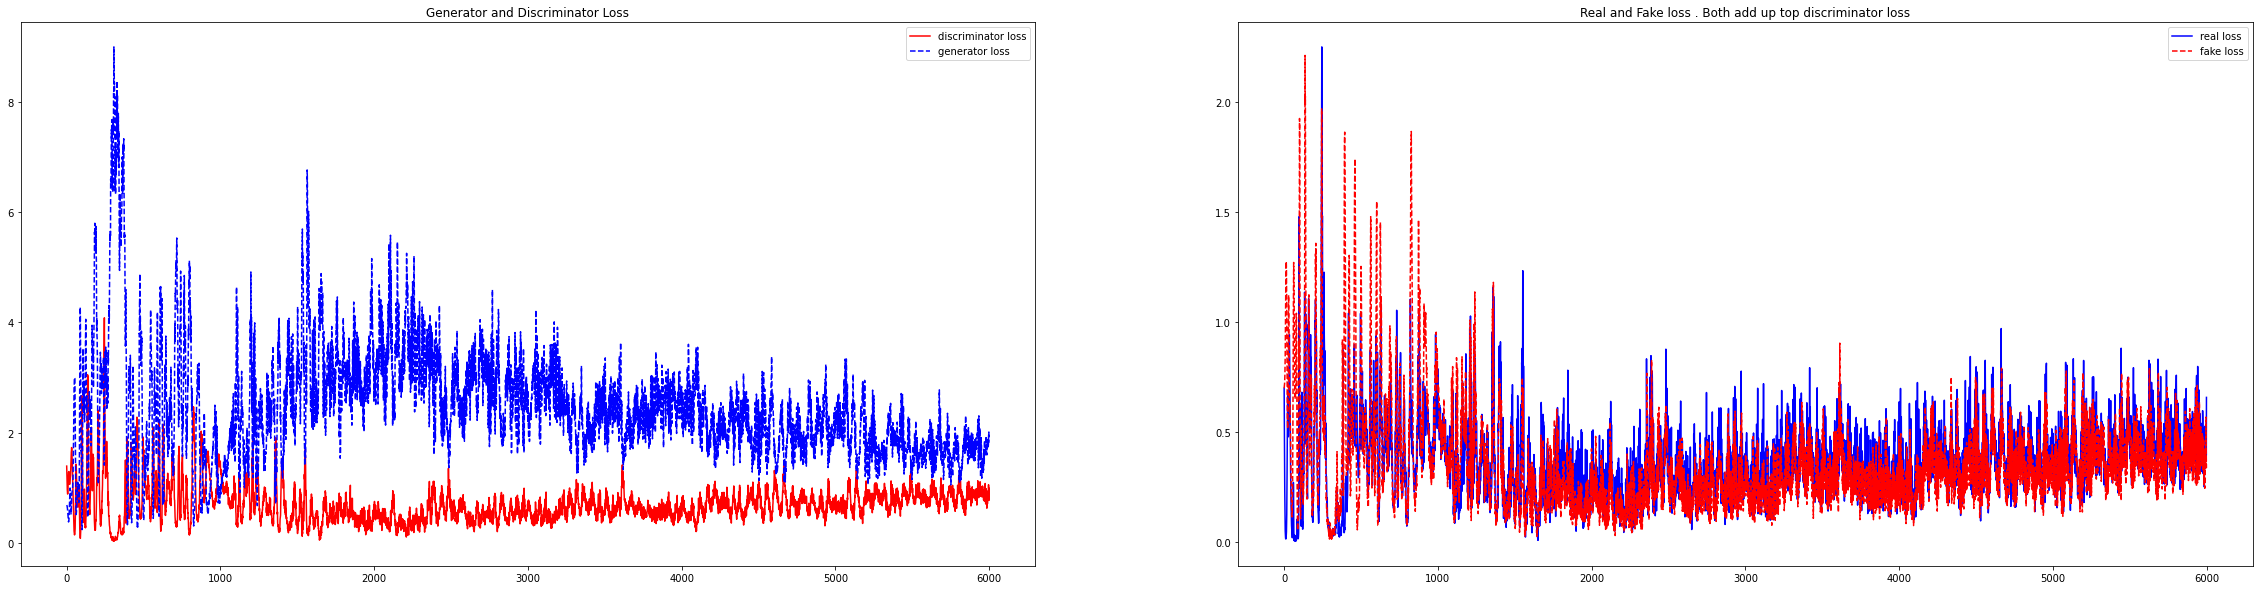

In [56]:
figure, axes = plt.subplots(1,2)
axes[0].plot(disloss_list, label = 'discriminator loss', color = 'red')
axes[0].plot(generatorlosslist, label = 'generator loss', color = 'blue', linestyle = 'dashed')
axes[0].set_title('Generator and Discriminator Loss')
axes[0].legend()

axes[1].plot(realloss, label = 'real loss', color = 'blue')
axes[1].plot(fakeloss, label = 'fake loss', color = 'red', linestyle = 'dashed')
axes[1].set_title('Real and Fake loss . Both add up top discriminator loss')
axes[1].legend()


figure.set_size_inches(w = 40,h = 10)